In [3]:
from maap.maap import MAAP
maap = MAAP()

# DPS the export of Google Earth Engine assets to MAAP

These assets were created and exported by tile via a loop in Google Earth Engine here:  
https://code.earthengine.google.com/?scriptPath=users%2Fmmacander%2Fveg_structure%3Asentinel_1%2Fseasonal_s1_tile_export_v2  
old version:  
https://code.earthengine.google.com/?scriptPath=users%2Fpaulmontesano%2Fdefault%3Aseasonal_s1_tile_export

and can be viewed here:  
https://code.earthengine.google.com/?scriptPath=users%2Fpaulmontesano%2Fdefault%3Aseasonal_s1_view

Here, the composites are created and shown on-the-fly:  
https://code.earthengine.google.com/?scriptPath=users%2Fpaulmontesano%2Fdefault%3Aseasonal_s1_comps

In [2]:
import ee
import numpy as np
import geopandas as gpd
import pandas as pd
import shapely
import glob
import os
from shapely.geometry import Polygon
from shapely.geometry import box
import matplotlib
import matplotlib.pyplot as plt
import rasterio as rio
import sys
sys.path.append('/projects/code/icesat2_boreal/lib')
import ExtractUtils

import datetime


NASA MAAP


In [3]:
#!aws s3 rm --recursive s3://maap-ops-workspace/montesano/dps_output/do_gee_download_by_subtile/EXPORT_GEE_v2/SAR_S1_2018/2023

## Authenticate current access to Google Earth Engine
Make a current credentials file; copy it to private bucket; get its s3 path to pass to script 

In [6]:
ee.Authenticate()

Enter verification code:  4/1AfJohXln0jsm3Nl_Bgx8Qh8laWLMxSr07CDCTXhiUS0_Xp5PNmOMBiKk05Q



Successfully saved authorization token.


In [4]:
USER = 'montesano' #'nathanmthomas'
#!mkdir -p $HOME/my-private-bucket/GEE/

In [5]:
!cp $HOME/.config/earthengine/credentials $HOME/my-private-bucket/

In [6]:
creds_fn = f'https://maap-ops-workspace.s3.amazonaws.com/{USER}/credentials'
creds_fn

'https://maap-ops-workspace.s3.amazonaws.com/montesano/credentials'

## Steps to commit, build DPS registration yaml, register DPS algorithm from yaml
### Commit with Tag for running
1) Add version name as a *tag_name* of `EXPORT_GEE_v1` or whatever is appropriate - both to this notebook and algorithm config yaml

2) follow git instructions (every time!!):  
 - git add changes  
 - git commit -m 'message'  
 - git tag -f `EXPORT_GEE_v2`    
 - git push  
 - git push origin -f `EXPORT_GEE_v2`  
        # --push to gitlab no longer needed --   
        # git push dps    
        # git push dps -f `EXPORT_GEE_v2`    

3) if it looks weird check git log to make sure tag is at same place as origin and dps

### Build DPS Registration yaml  
- use MAAP Register Algorithm tool  
- refer to `code/icesat2_boreal/dps/registered/do_export_gee_to_maap.yml` for existing template  
- update reg yaml repository url to the github url (gitlab no longer needed) 
- update `above_env.yml` and `build_command_main.sh` to include all pinned versions of packages - to ensure stability of env for this alg  

# Register algorithm for DPS

### Use Registration yaml: Register DPS algorithm
 - We need to register the DPS algorithm before proceeding to the chunks below...

In [234]:
maap.register_algorithm_from_yaml_file("/projects/code/icesat2_boreal/dps/registered/do_gee_download_by_subtile.yml").text

'{"code": 200, "message": {"id": "d646cc702fadf2556197a5bae06aa5119983d069", "short_id": "d646cc70", "created_at": "2023-10-10T20:01:10.000+00:00", "parent_ids": ["a2819add25170aee1ffaa656f1fabae2d8a42add"], "title": "Registering algorithm: do_gee_download_by_subtile", "message": "Registering algorithm: do_gee_download_by_subtile", "author_name": "root", "author_email": "root@d77d51470ba9", "authored_date": "2023-10-10T20:01:10.000+00:00", "committer_name": "root", "committer_email": "root@d77d51470ba9", "committed_date": "2023-10-10T20:01:10.000+00:00", "trailers": {}, "web_url": "https://repo.maap-project.org/root/register-job-hysds-v4/-/commit/d646cc702fadf2556197a5bae06aa5119983d069", "stats": {"additions": 2, "deletions": 2, "total": 4}, "status": "pending", "project_id": 3, "last_pipeline": {"id": 8459, "iid": 240, "project_id": 3, "sha": "d646cc702fadf2556197a5bae06aa5119983d069", "ref": "main", "status": "pending", "source": "push", "created_at": "2023-10-10T20:01:11.660Z", "up

# DPS test

### Use MAAP gui to View & Submit a single test job
check status here

In [7]:
# MAAP algorithm version name
MAAP_VERSION = "EXPORT_GEE_v2"

In [8]:
%%time
submitted_job_dict = maap.submitJob(
                identifier='TEST_SAR_S1_2018',
                algo_id="do_gee_download_by_subtile",
                version=MAAP_VERSION,
               username="montesano",
               queue="maap-dps-worker-8gb",
               creds_fn = 's3://maap-ops-workspace/montesano/credentials',
               subtile_loc="2",
               id_num="3",
               id_col='AGG_TILE_NUM',
               tile_size_m=500,
               asset_path="projects/foreststructure/Circumboreal/S1_Composites_albers",
               out_dir="''")

CPU times: user 27.5 ms, sys: 0 ns, total: 27.5 ms
Wall time: 127 ms


In [64]:
submitted_job_dict.status

'success'

In [65]:
submitted_job_dict.id

'1f339f6a-dc85-45b8-9c18-508540fc7ee1'

In [68]:
print(submitted_job_dict)

{'job_id': '1f339f6a-dc85-45b8-9c18-508540fc7ee1', 'status': 'success', 'machine_type': None, 'architecture': None, 'machine_memory_size': None, 'directory_size': None, 'operating_system': None, 'job_start_time': None, 'job_end_time': None, 'job_duration_seconds': None, 'cpu_usage': None, 'cache_usage': None, 'mem_usage': None, 'max_mem_usage': None, 'swap_usage': None, 'read_io_stats': None, 'write_io_stats': None, 'sync_io_stats': None, 'async_io_stats': None, 'total_io_stats': None, 'error_details': None, 'response_code': 200, 'outputs': []}


# DPS
### Fishnet of subtiles needed on the fly for each agg tile

In [23]:
import importlib
import do_gee_download_by_subtile
importlib.reload(do_gee_download_by_subtile)

<module 'do_gee_download_by_subtile' from '/projects/code/icesat2_boreal/lib/do_gee_download_by_subtile.py'>

In [11]:
CREDS_FN = 's3://maap-ops-workspace/montesano/credentials'

In [12]:
MAAP_VERSION = "EXPORT_GEE_v2"
IDENTIFIER = 'SAR_S1_2018'
ALGO_ID = "do_gee_download_by_subtile"
USER = 'montesano'
WORKER_TYPE = 'maap-dps-worker-8gb'

## Multiprocess DPS submission
Might be the best way of doing this

In [13]:
#### If DPSing by subtile, you need ASSET_PATH to get gee asset_df and TILELOC to get the tile form asset_df to make its fishnet even before you call 'do_gee_download_by_subtile'
ASSET_PATH = 'projects/foreststructure/Circumboreal/S1_Composites_albers'

# We need this asset_df to know how to loop over asset tiles - but the script also needs it during processing and to use it to build a fishnet_df 
asset_df = do_gee_download_by_subtile.get_gee_assets(ASSET_PATH)
asset_df = pd.concat([asset_df.drop(['properties'], axis=1), asset_df['properties'].apply(pd.Series)], axis=1) # makes the AGG_TILE_NUM field available

TILE_FIELD_NAME = 'AGG_TILE_NUM'
TILE_SIZE_M = 500

### Build list of params for DPS submission

In [47]:
%%time

if True:
    
    DPS_ASSET_TILE_LIST = asset_df.index.to_list()
    DPS_ASSET_TILE_LIST = sorted(asset_df[TILE_FIELD_NAME].to_list()) # this field now available

    submit_results_df_list = []
    n_subtiles_total = 0

    LIST_in_param_dict = []
    fishnet_4326_list = []

    for ASSET_TILE in DPS_ASSET_TILE_LIST:
        
        if True:
            # This should work now - untested here as of 12/14/2023
            ASSET_TILE_NAME, fishnet_4326 = MAKE_ASSET_TILE_SUBTILES(ASSET_TILE, asset_df, TILE_FIELD_NAME=TILE_FIELD_NAME, TILE_SIZE_M=TILE_SIZE_M)
        else:
            # Delete this 'else' if the above works
            #ASSET_TILE_NAME = os.path.basename(asset_df.id.to_list()[TILELOC])
            ASSET_TILE_NAME = os.path.basename(asset_df[asset_df[TILE_FIELD_NAME]==ASSET_TILE].id.to_list()[0])

            # 
            # Get fishnet of subtiles on the fly to DPS subtile submission
            #
            #fishnet_df = do_gee_download_by_subtile.create_fishnet(asset_df, TILELOC, 500) # !! This number must be the same as what is in the script
            fishnet_df = do_gee_download_by_subtile.create_fishnet(asset_df[asset_df[TILE_FIELD_NAME] == ASSET_TILE], TILE_SIZE_M)
            fishnet_df['subtile'] = fishnet_df.index
            fishnet_df['tile'] = ASSET_TILE

            fishnet_4326 = fishnet_df.to_crs("EPSG:4326")
            
        fishnet_4326_list.append(fishnet_4326)

        n_subtiles = fishnet_4326.shape[0]
        n_subtiles_total += n_subtiles

        ## This will multprocess the glob for unfinished subtiles
        # Get full index list
        LIST_SUBTILE_INDEX_TO_DPS = [index for index, row in fishnet_4326.iterrows()]

        len_input_list = len(LIST_SUBTILE_INDEX_TO_DPS)
        print(f'GEE Asset tile #: {ASSET_TILE} name: {ASSET_TILE_NAME} # of input subtiles for DPS: {len_input_list} (subtile size = {TILE_SIZE_M}m)')

        # Loop over DPS submissions of each Agg tile's subtiles
        for INPUT_SUBTILE_NUM in LIST_SUBTILE_INDEX_TO_DPS:

            in_param_dict = {
                                'creds_fn' : CREDS_FN,
                                 'subtile_loc': INPUT_SUBTILE_NUM,
                                 'id_num': ASSET_TILE,
                                 'id_col': TILE_FIELD_NAME,
                                 'tile_size_m': TILE_SIZE_M,
                                 'asset_path': ASSET_PATH

                }

            LIST_in_param_dict.append(in_param_dict)


    if True:
        # Save the subtile gdf for later use with build_tindex
        S1_subtile_gdf = pd.concat(fishnet_4326_list)
        S1_subtile_gdf.to_file(f'/projects/my-public-bucket/DPS_tile_lists/SAR/{MAAP_VERSION}/{IDENTIFIER}/S1_{TILE_FIELD_NAME}_subtiles.gpkg', driver='GPKG')   

GEE Asset tile #: 1 name: s1_vv_vh_gamma_2018_pwr_tile01 # of input subtiles for DPS: 3136 (subtile size = 500m)
GEE Asset tile #: 2 name: s1_vv_vh_gamma_2018_pwr_tile02 # of input subtiles for DPS: 3136 (subtile size = 500m)
GEE Asset tile #: 3 name: s1_vv_vh_gamma_2018_pwr_tile03 # of input subtiles for DPS: 3136 (subtile size = 500m)
GEE Asset tile #: 4 name: s1_vv_vh_gamma_2018_pwr_tile04 # of input subtiles for DPS: 3080 (subtile size = 500m)
GEE Asset tile #: 5 name: s1_vv_vh_gamma_2018_pwr_tile05 # of input subtiles for DPS: 3080 (subtile size = 500m)
GEE Asset tile #: 6 name: s1_vv_vh_gamma_2018_pwr_tile06 # of input subtiles for DPS: 3080 (subtile size = 500m)
GEE Asset tile #: 7 name: s1_vv_vh_gamma_2018_pwr_tile07 # of input subtiles for DPS: 3080 (subtile size = 500m)
GEE Asset tile #: 8 name: s1_vv_vh_gamma_2018_pwr_tile08 # of input subtiles for DPS: 3136 (subtile size = 500m)
GEE Asset tile #: 9 name: s1_vv_vh_gamma_2018_pwr_tile09 # of input subtiles for DPS: 3136 (subt

### Test locally

In [61]:
import rasterio
from rasterio.plot import show_hist, show


In [111]:
importlib.reload(do_gee_download_by_subtile)

OUTDIR_TILE = '/projects/my-public-bucket/local_output/do_gee_download_by_subtile_TEST'
do_gee_download_by_subtile.do_gee_download_by_subtile(SUBTILE_LOC=2501, ID_NUM=75, ID_COL='AGG_TILE_NUM', ASSET_PATH=ASSET_PATH, TILE_SIZE_M=500, OUTDIR=OUTDIR_TILE)



	Subtile 2501 for AGG_TILE_NUM # 75 (s1_vv_vh_gamma_2018_pwr_tile75) to subdir: /projects/my-public-bucket/local_output/do_gee_download_by_subtile_TEST/s1_vv_vh_gamma_2018_pwr_tile75
	SUBTILE_LOC: 2501 : extracted tifs to /projects/my-public-bucket/local_output/do_gee_download_by_subtile_TEST/s1_vv_vh_gamma_2018_pwr_tile75-subtile002501
Multiband geotiff created successfully at: /projects/my-public-bucket/local_output/do_gee_download_by_subtile_TEST/s1_vv_vh_gamma_2018_pwr_tile75-subtile002501/s1_vv_vh_gamma_2018_pwr_tile75-subtile002501.tif


[]

In [31]:
f'{os.path.dirname(stack_vrt_fn)}/*.tif'

'/projects/my-public-bucket/local_output/do_gee_download_by_subtile_TEST/s1_vv_vh_gamma_2018_pwr_tile01-subtile000000/*.tif'

In [43]:
import subprocess
stack_vrt_fn = '/projects/my-public-bucket/local_output/do_gee_download_by_subtile_TEST/s1_vv_vh_gamma_2018_pwr_tile01-subtile000000/s1_vv_vh_gamma_2018_pwr_tile01-subtile000000.vrt'
process = subprocess.run(['/projects/env/above/bin/gdalbuildvrt', '-separate', f'{stack_vrt_fn}', os.path.dirname(stack_vrt_fn)+'/*.tif'], 
                         stdout=subprocess.PIPE, universal_newlines=True)


Warning 1: Can't open /projects/my-public-bucket/local_output/do_gee_download_by_subtile_TEST/s1_vv_vh_gamma_2018_pwr_tile01-subtile000000/*.tif. Skipping it


## Read in gdf of missing subtiles and build list of params for DPS multiprocessing 
### `TODO` where was S1_subtiles_missing.gpkg created???

In [56]:
S1_subtile_gdf_missing = gpd.read_file(f'/projects/my-public-bucket/DPS_tile_lists/SAR/{MAAP_VERSION}/{IDENTIFIER}/S1_subtiles_missing.gpkg')
S1_subtile_gdf_missing.shape

(36595, 6)

In [57]:
#S1_subtile_gdf_missing.tail(1000).explore()

In [58]:
# Get the unique list of agg tiles with missing subtiles
DPS_ASSET_TILE_LIST = list(set(S1_subtile_gdf_missing.tile_num.to_list()))

LIST_in_param_dict = []
for ASSET_TILE in DPS_ASSET_TILE_LIST:
    ASSET_TILE_NAME = os.path.basename(asset_df[asset_df[TILE_FIELD_NAME]==ASSET_TILE].id.to_list()[0])

    # For current agg tile, get the list of missing subtiles
    subset_df = S1_subtile_gdf_missing[S1_subtile_gdf_missing.tile_num == ASSET_TILE]
    LIST_SUBTILE_INDEX_TO_DPS = subset_df.subtile_num.to_list()
    
    len_input_list = len(LIST_SUBTILE_INDEX_TO_DPS)
    print(f'GEE Asset tile #: {ASSET_TILE} name: {ASSET_TILE_NAME} # of input subtiles for DPS: {len_input_list} (subtile size = {TILE_SIZE_M}m)')
    
    # Loop over DPS submissions of each Agg tile's subtiles
    for INPUT_SUBTILE_NUM in LIST_SUBTILE_INDEX_TO_DPS:
         
        in_param_dict = {
                            'creds_fn' : CREDS_FN,
                             'subtile_loc': INPUT_SUBTILE_NUM,
                             'id_num': ASSET_TILE,
                             'id_col': TILE_FIELD_NAME,
                             'tile_size_m': TILE_SIZE_M,
                             'asset_path': ASSET_PATH

            }
        
        LIST_in_param_dict.append(in_param_dict)

GEE Asset tile #: 1 name: s1_vv_vh_gamma_2018_pwr_tile01 # of input subtiles for DPS: 485 (subtile size = 500m)
GEE Asset tile #: 2 name: s1_vv_vh_gamma_2018_pwr_tile02 # of input subtiles for DPS: 709 (subtile size = 500m)
GEE Asset tile #: 3 name: s1_vv_vh_gamma_2018_pwr_tile03 # of input subtiles for DPS: 1112 (subtile size = 500m)
GEE Asset tile #: 4 name: s1_vv_vh_gamma_2018_pwr_tile04 # of input subtiles for DPS: 1101 (subtile size = 500m)
GEE Asset tile #: 5 name: s1_vv_vh_gamma_2018_pwr_tile05 # of input subtiles for DPS: 1146 (subtile size = 500m)
GEE Asset tile #: 6 name: s1_vv_vh_gamma_2018_pwr_tile06 # of input subtiles for DPS: 906 (subtile size = 500m)
GEE Asset tile #: 7 name: s1_vv_vh_gamma_2018_pwr_tile07 # of input subtiles for DPS: 436 (subtile size = 500m)
GEE Asset tile #: 8 name: s1_vv_vh_gamma_2018_pwr_tile08 # of input subtiles for DPS: 991 (subtile size = 500m)
GEE Asset tile #: 9 name: s1_vv_vh_gamma_2018_pwr_tile09 # of input subtiles for DPS: 1116 (subtile s

In [48]:
len(LIST_in_param_dict)

455217

In [207]:
# # Save the subtile gdf for later use with build_tindex
# S1_subtile_gdf = pd.concat(fishnet_4326_list)
# S1_subtile_gdf.to_file('/projects/my-public-bucket/DPS_tile_lists/SAR/EXPORT_GEE_v1/SAR_S1_2018/S1_subtiles.gpkg', driver='GPKG')

In [63]:
from multiprocessing import Pool
from functools import partial

In [50]:
LIST_in_param_dict[-1]

{'creds_fn': 's3://maap-ops-workspace/montesano/credentials',
 'subtile_loc': 23311,
 'id_num': 110,
 'id_col': 'AGG_TILE_NUM',
 'tile_size_m': 500,
 'asset_path': 'projects/foreststructure/Circumboreal/S1_Composites_albers'}

### Set up wrapper for multiprocessing submission

In [69]:
def wrapper_submitJob(in_param_dict, identifier=IDENTIFIER, algo_id=ALGO_ID, version=MAAP_VERSION, username=USER, queue=WORKER_TYPE):
    
    submit_result = maap.submitJob(identifier=identifier, algo_id=algo_id, version=version, username=username, queue=queue, **in_param_dict)
    
    DPS_num = 'NA' # useful for serial submission - kept here for consistency in output submission tables
    
    # Build a dataframe of submission details
    submit_result_df = pd.DataFrame( 
            {
                    'dps_num':[DPS_num],
                    'tile_num':[in_param_dict['id_num']],
                    'subtile_num': [[in_param_dict['subtile_loc']][0]],
                    'submit_time':[datetime.datetime.now()],
                    'dbs_job_hour': [datetime.datetime.now().hour],
                    'algo_id': [ALGO_ID],
                    'user': [USER],
                    'worker_type': [WORKER_TYPE],
                    'job_id': [submit_result.id],
                    'submit_status': [submit_result.status],

            } 
        )
    if False:
        submit_result_df['run_name'] = IDENTIFIER

        out_submit_result_fn = f'/projects/my-public-bucket/dps_submission_results/DPS_{ALGO_ID}_{IDENTIFIER}_{MAAP_VERSION}_submission_results.csv'
        if os.path.isfile(out_submit_result_fn):
            submit_result_df.to_csv(out_submit_result_fn, mode='a', header=False)
        else:
            submit_result_df.to_csv(out_submit_result_fn)

    return submit_result_df

In [128]:
len(LIST_in_param_dict)

455217

In [61]:
LIST_in_param_dict[0]

{'creds_fn': 's3://maap-ops-workspace/montesano/credentials',
 'subtile_loc': 0,
 'id_num': 1,
 'id_col': 'AGG_TILE_NUM',
 'tile_size_m': 500,
 'asset_path': 'projects/foreststructure/Circumboreal/S1_Composites_albers'}

In [115]:
importlib.reload(ExtractUtils)

NASA MAAP


<module 'ExtractUtils' from '/projects/code/icesat2_boreal/lib/ExtractUtils.py'>

## DPS job submission in parallel
request that the devs increase the # of 8GB workers available

In [ ]:
%%time
INPUT_LIST = LIST_in_param_dict[160410:] # Restart like this: from dps-job-management; can figure out a total job submitted using filters 

len_input_list = len(INPUT_LIST)

with Pool(processes=30) as pool:
    submit_result_df_list = pool.map(partial(wrapper_submitJob), INPUT_LIST)
    
# Build a final submission results df and save
submit_results_df = pd.concat(submit_result_df_list)
submit_results_df['run_name'] = IDENTIFIER
nowtime = pd.Timestamp.now().strftime('%Y%m%d%H%M')
print(f"Current time:\t{nowtime}")
submit_results_df.to_csv(f'/projects/my-public-bucket/dps_submission_results/DPS_{ALGO_ID}_{IDENTIFIER}_{MAAP_VERSION}_submission_results_{len_input_list}_{nowtime}.csv')
submit_results_df.info()

In [ ]:
submit_results_df.head()

## Run a tindex

In [14]:
DICT_BUILD_TINDEX_SAR = {
    'SET' : 'SAR',
    'USER' : USER,
    'ALG_NAME' : ALGO_ID,
    'ALG_VERSION' : MAAP_VERSION,
    'VAR' : 'S1',
    # In my bucket, this is ALWAYS used to identify output
    'BATCH_NAME' : IDENTIFIER,
    'DPS_MONTH_LIST' : '12',        
    'DPS_DAY_MIN' : 1 ,
    'TILES_INDEX_PATH': '/projects/my-public-bucket/databank/boreal_tiles_v003_agg9/boreal_tiles_v003_agg9_subtiles_500m.gpkg'
}

In [16]:
DICT_BUILD_TINDEX = DICT_BUILD_TINDEX_SAR
DICT_BUILD_TINDEX

{'SET': 'SAR',
 'USER': 'montesano',
 'ALG_NAME': 'do_gee_download_by_subtile',
 'ALG_VERSION': 'EXPORT_GEE_v2',
 'VAR': 'S1',
 'BATCH_NAME': 'SAR_S1_2018',
 'DPS_MONTH_LIST': '12',
 'DPS_DAY_MIN': 1,
 'TILES_INDEX_PATH': '/projects/my-public-bucket/databank/boreal_tiles_v003_agg9/boreal_tiles_v003_agg9_subtiles_500m.gpkg'}

In [19]:
%%time

DPS_IDENTIFIER = f"{DICT_BUILD_TINDEX['ALG_VERSION']}/{DICT_BUILD_TINDEX['BATCH_NAME']}"

OUTDIR = f"/projects/my-public-bucket/DPS_tile_lists/{DICT_BUILD_TINDEX['SET']}/{DPS_IDENTIFIER}"
!mkdir -p $OUTDIR

# Build tindex
args = f"--RETURN_DUPS --user {DICT_BUILD_TINDEX['USER']} --dps_identifier {DPS_IDENTIFIER} \
-alg_name {DICT_BUILD_TINDEX['ALG_NAME']} -t {DICT_BUILD_TINDEX['VAR']} -y 2023 \
--dps_month_list {DICT_BUILD_TINDEX['DPS_MONTH_LIST']} -d_min {DICT_BUILD_TINDEX['DPS_DAY_MIN']} --outdir {OUTDIR} \
-boreal_tile_index_path {DICT_BUILD_TINDEX['TILES_INDEX_PATH']}"

!time echo /projects/env/above/bin/python /projects/code/icesat2_boreal/lib/build_tindex_master.py $args --WRITE_TINDEX_MATCHES_GDF

/projects/env/above/bin/python /projects/code/icesat2_boreal/lib/build_tindex_master.py --RETURN_DUPS --user montesano --dps_identifier EXPORT_GEE_v2/SAR_S1_2018 -alg_name do_gee_download_by_subtile -t S1 -y 2023 --dps_month_list 12 -d_min 1 --outdir /projects/my-public-bucket/DPS_tile_lists/SAR/EXPORT_GEE_v2/SAR_S1_2018 -boreal_tile_index_path /projects/my-public-bucket/databank/boreal_tiles_v003_agg9/boreal_tiles_v003_agg9_subtiles_500m.gpkg --WRITE_TINDEX_MATCHES_GDF

real	0m0.000s
user	0m0.000s
sys	0m0.000s
CPU times: user 12.2 ms, sys: 20.6 ms, total: 32.9 ms
Wall time: 421 ms


## Map the DPS'd subtiles

/projects/code/icesat2_boreal/lib/ExtractUtils.py:555: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres") )


(51722, 5)

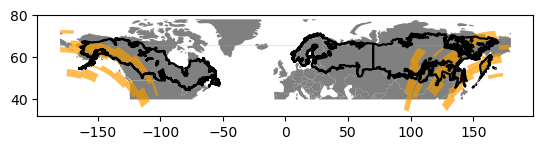

In [20]:
json_fn = 's3://maap-ops-workspace/shared/montesano/DPS_tile_lists/SAR/EXPORT_GEE_v2/SAR_S1_2018/S1_tindex_master.json'
gdf = ExtractUtils.make_gdf_from_json(json_fn) 
ExtractUtils.show_tiles_map(gdf)
gdf.shape

## Build a footprint of subtiles that are expected

Putting these 'expected' subtiles in `databank` but `MAKE_ASSET_TILE_SUBTILES()` also run above and written to `my-public-bucket/DPS_tile_lists/SAR/EXPORT_GEE_v2/SAR_S1_2018/S1_AGG_TILE_NUM_subtiles.gpkg`

In [90]:
fishnet_4326_list = []
for AGG_TILE_NUM in asset_df.AGG_TILE_NUM.to_list():
    print(AGG_TILE_NUM)
    ASSET_TILE_NAME, fishnet_4326 = MAKE_ASSET_TILE_SUBTILES(AGG_TILE_NUM, asset_df, TILE_FIELD_NAME=TILE_FIELD_NAME, TILE_SIZE_M=TILE_SIZE_M)
    fishnet_4326_list.append(fishnet_4326)

z = pd.concat(fishnet_4326_list)
z.to_file(f'/projects/my-public-bucket/databank/boreal_tiles_v003_agg9/boreal_tiles_v003_agg9_subtiles_{TILE_SIZE_M}m.gpkg', driver='GPKG')

1
2
3
4
5
6
7
8
9
10
101
102
103
104
105
106
107
108
109
11
110
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
95
96
97
98
99
93


In [88]:
z.head()

,geometry,subtile,tile
0,"POLYGON ((128.60784 34.41330, 128.50042 34.515...",0,1
1,"POLYGON ((128.71972 34.51187, 128.61231 34.614...",1,1
2,"POLYGON ((128.83196 34.61022, 128.72457 34.713...",2,1
3,"POLYGON ((128.94455 34.70836, 128.83718 34.811...",3,1
4,"POLYGON ((129.05751 34.80629, 128.95015 34.909...",4,1


<Axes: >

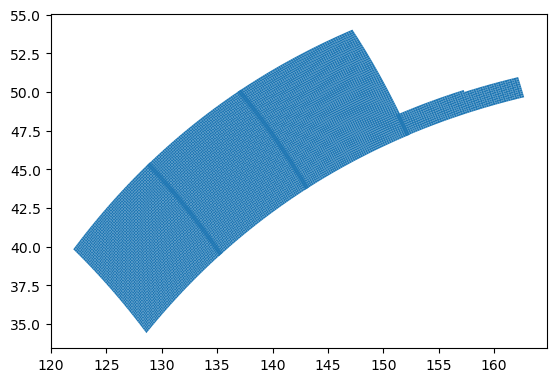

In [84]:
z.head(10000).plot()

# ---------------------------------------  

# DPS - serial job submission (slow)

In [89]:
def MAKE_ASSET_TILE_SUBTILES(AGG_TILE_NUM, asset_df, TILE_FIELD_NAME='AGG_TILE_NUM', TILE_SIZE_M=500):
    '''
    For an asset tile from GEE, create subtiles of a give size.
    This can be used to create a mosaic json of the subtiles of the assets transferred from GEE
    The mosiac json is used to view in notebook maps to check for completeness of DPS runs of these asset transfers
    '''
    if False:
        DPS_ASSET_TILE_LIST = asset_df.index.to_list()
        ASSET_TILE = DPS_ASSET_TILE_LIST.index(AGG_TILE_NUM+1)
        DPS_ASSET_TILE_LIST = sorted(asset_df['AGG_TILE_NUM'].to_list()) # this field now available
        ASSET_TILE = DPS_ASSET_TILE_LIST.index(AGG_TILE_NUM+1)
    ASSET_TILE = AGG_TILE_NUM

    ASSET_TILE_NAME = os.path.basename(asset_df[asset_df[TILE_FIELD_NAME]==ASSET_TILE].id.to_list()[0])

    # 
    # Get fishnet of subtiles on the fly to DPS subtile submission
    #
    fishnet_df = do_gee_download_by_subtile.create_fishnet(asset_df[asset_df[TILE_FIELD_NAME] == ASSET_TILE], TILE_SIZE_M)
    fishnet_df['subtile_num'] = fishnet_df.index
    fishnet_df['tile_num'] = ASSET_TILE

    fishnet_4326 = fishnet_df.to_crs("EPSG:4326")
    
    return ASSET_TILE_NAME, fishnet_4326

In [40]:
ASSET_PATH = 'projects/foreststructure/Circumboreal/S1_Composites_albers'

# We need this asset_df to know how to loop over asset tiles - but the script also needs it during processing and to use it to build a fishnet_df 
asset_df = do_gee_download_by_subtile.get_gee_assets(ASSET_PATH)
asset_df = pd.concat([asset_df.drop(['properties'], axis=1), asset_df['properties'].apply(pd.Series)], axis=1) # makes the AGG_TILE_NUM field available

asset_df.head()

ASSET_TILE_NAME = os.path.basename(asset_df.id.to_list()[0])
ASSET_TILE_NAME

's1_vv_vh_gamma_2018_pwr_tile01'

In [42]:
%%time

#### If DPSing by subtile, you need ASSET_PATH to get gee asset_df and TILELOC to get the tile form asset_df to make its fishnet even before you call 'do_gee_download_by_subtile'
ASSET_PATH = 'projects/foreststructure/Circumboreal/S1_Composites_albers'

# We need this asset_df to know how to loop over asset tiles - but the script also needs it during processing and to use it to build a fishnet_df 
asset_df = do_gee_download_by_subtile.get_gee_assets(ASSET_PATH)
asset_df = pd.concat([asset_df.drop(['properties'], axis=1), asset_df['properties'].apply(pd.Series)], axis=1) # makes the AGG_TILE_NUM field available

DPS_ASSET_TILE_LIST = asset_df.index.to_list()
# Potential to iterate over AGG TILE  NUM instead of 'index'?
#DPS_ASSET_TILE_LIST = sorted(asset_df['AGG_TILE_NUM'].to_list()) # this field now available

submit_results_df_list = []
n_subtiles_total = 0

TILE_SIZE_M = 500

DPS_num = 0
for TILELOC in DPS_ASSET_TILE_LIST[0:2]:

    
    ASSET_TILE_NAME = os.path.basename(asset_df.id.to_list()[TILELOC])
    
    print(f'GEE Asset tile loc # {TILELOC} will go an asset tile dir: {ASSET_TILE_NAME}')
    
    # 
    # Get fishnet of subtiles on the fly to DPS subtile submission
    #
    fishnet_df = do_gee_download_by_subtile.create_fishnet(asset_df, TILELOC, TILE_SIZE_M) # !! This number must be the same as what is in the script
    fishnet_df['subtile'] = fishnet_df.index
    fishnet_df['tile'] = TILELOC
    
    fishnet_4326 = fishnet_df.to_crs("EPSG:4326")

    n_subtiles = fishnet_4326.shape[0]
    n_subtiles_total += n_subtiles
    
    ## This will multprocess the glob for unfinished subtiles
    # Get full index list
    LIST_SUBTILE_INDEX_TO_DPS = [index for index, row in fishnet_4326.iterrows()]
    
    len_input_list = len(LIST_SUBTILE_INDEX_TO_DPS)
    print(f"# of input subtiles for DPS over asset tile {TILELOC}: {len_input_list}")
    
    # Loop over DPS submissions of each Agg tile's subtiles
    for INPUT_SUBTILE_NUM in LIST_SUBTILE_INDEX_TO_DPS:
        
        DPS_num += 1
    
        in_param_dict = {
                             'creds_fn' : CRED_FN,
                             'subtile_loc': INPUT_SUBTILE_NUM,
                             'tile_loc': TILELOC,
                             'asset_path': ASSET_PATH,
                            'tile_size_m': TILE_SIE_M

            }

        submit_result = maap.submitJob(
                                        identifier=IDENTIFIER,
                                        algo_id=ALGO_ID,
                                        version=MAAP_VERSION,
                                        username=USER,
                                        queue=WORKER_TYPE,
                                        # Args that match yaml
                                        **in_param_dict
            )

        # Build a dataframe of submission details
        submit_result_df = pd.DataFrame( 
            {
                    'dps_num':[DPS_num],
                    'tile_num':[TILELOC],
                    'subtile_num': [INPUT_SUBTILE_NUM],
                    'submit_time':[datetime.datetime.now()],
                    'dbs_job_hour': [datetime.datetime.now().hour],
                    'algo_id': [ALGO_ID],
                    'user': [USER],
                    'worker_type': [WORKER_TYPE],
                    'job_id': [submit_result.id],
                    'submit_status': [submit_result.retrieve_status()],

            } 
        )

        # Append to a list of data frames of submission results
        submit_results_df_list.append(submit_result_df)

        if DPS_num in [1, 5, 10, 50, 100, 250, 500, 750, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 7000, 9000, 11000, 13000, 15000, 17000, 19000, 21000, 24000, 25000, n_subtiles_total]:
            print(f"DPS run #: {DPS_num}\t| Tile loc: {TILELOC}\t| subtile: {INPUT_SUBTILE_NUM}\t| submit status: {submit_result.retrieve_status()}\t| job id: {submit_result.id}") 

# Build a final submission results df and save
submit_results_df = pd.concat(submit_results_df_list)
submit_results_df['run_name'] = IDENTIFIER
nowtime = pd.Timestamp.now().strftime('%Y%m%d%H%M')
print(f"Current time:\t{nowtime}")
submit_results_df.to_csv(f'/projects/my-public-bucket/dps_submission_results/DPS_{ALGO_ID}_{IDENTIFIER}_submission_results_{len_input_list}_{nowtime}.csv')
submit_results_df.info()

GEE Asset tile loc # 0 will go an asset tile dir: s1_vv_vh_gamma_2018_pwr_tile01
	bbox Albers= -4506720 2043330 -3681390 1218060


KeyboardInterrupt: 

In [128]:
# submit_results_df.reset_index(drop=True, inplace=True)
submit_results_df.head()

,dps_num,tile_num,subtile_num,submit_time,dbs_job_hour,algo_id,user,worker_type,job_id,submit_status,run_name
0,415719,12,0,2023-10-09 02:21:01.439016,2,do_gee_download_by_subtile,montesano,maap-dps-worker-8gb,7f9f1d33-1d12-4bf7-ad50-9b6e51fe083a,Accepted,SAR_S1_2018
0,415719,12,1,2023-10-09 02:21:01.753448,2,do_gee_download_by_subtile,montesano,maap-dps-worker-8gb,8f9040de-2fd7-43de-8de6-dd31eb78c61e,Accepted,SAR_S1_2018
0,415719,12,2,2023-10-09 02:21:01.744644,2,do_gee_download_by_subtile,montesano,maap-dps-worker-8gb,11be8e54-93a1-492d-ac0a-8aaa802852ed,Accepted,SAR_S1_2018
0,415719,12,3,2023-10-09 02:20:56.375547,2,do_gee_download_by_subtile,montesano,maap-dps-worker-8gb,e30ad2df-10c2-42b3-acf4-6850f4c7895d,Accepted,SAR_S1_2018
0,415719,12,4,2023-10-09 02:21:02.366877,2,do_gee_download_by_subtile,montesano,maap-dps-worker-8gb,8df21ad2-7a6a-4ce2-a55e-0f5ebf7353aa,Accepted,SAR_S1_2018


After almost any DPS job, you have to assess what succeeded and failed. This involves:
1. building a table of job status based on job ids captured in the job_results_df from the DPS run chunk (this takes 40 mins for ~47k jobs) --> this tells you how many jobs failed
2. merging the job status table with the job results df --> this tells you which specific granules (or tile nums) failed
3. building another input list of granules for a follow-up DPS
## Assess DPS results
Build a table of job status based on job id - how many jobs failed?

In [454]:
LIST_SUBMISSIONS = sorted(glob.glob(f'/projects/my-public-bucket/dps_submission_results/DPS_{ALGO_ID}_{IDENTIFIER}_submission_results_*.csv'), key=ExtractUtils.func, reverse=True)[0:1]
LIST_SUBMISSIONS

['/projects/my-public-bucket/dps_submission_results/DPS_do_gee_download_by_subtile_TEST2_SAR_S1_2018_submission_results_5_202310102121.csv']

In [455]:
%%time

running_list = []
fails_list = []
success_list = []

for fn in LIST_SUBMISSIONS:
    if not 'job_status' in fn:

        DPS_alg_id = os.path.basename(fn.split('_submission_results_')[0].replace('DPS_',''))
        thentime = fn.split('_')[-1].replace('.csv','')
        print(f'DPS alg:\t\t{DPS_alg_id}')
        print(f'DPS run name:\t\t{IDENTIFIER}')
        print(f'DPS launch time:\t{thentime}')
        df_jstatus = ExtractUtils.BUILD_TABLE_JOBSTATUS(pd.read_csv(fn))
        # Save job status table
        df_jstatus.to_csv(f'/projects/my-public-bucket/dps_submission_results/DPS_{ALGO_ID}_{IDENTIFIER}_submission_results_job_status_{len(df_jstatus)}_{thentime}.csv')

        # Get current fails df and append to list
        df_jstatus['run_type'] = IDENTIFIER
        running_list.append(df_jstatus[ (df_jstatus['status'] == 'Running') ] )
        fails_list.append(  df_jstatus[ (df_jstatus['status'] == 'Failed') ] )
        success_list.append(df_jstatus[ (df_jstatus['status'] == 'Succeeded') ] )
            
df_all_running = pd.concat(running_list)          
df_all_fails =   pd.concat(fails_list)
df_all_success = pd.concat(success_list)

DPS alg:		do_gee_download_by_subtile_TEST2_SAR_S1_2018
DPS run name:		TEST2_SAR_S1_2018
DPS launch time:	202310102121
Count total jobs:	5
Count pending jobs:	0
Count running jobs:	0
Count succeeded jobs:	5
Count failed jobs:	0
% of failed jobs:	Nothing has failed...yet

CPU times: user 104 ms, sys: 7.83 ms, total: 111 ms
Wall time: 421 ms


In [46]:
if False:
    !aws s3 rm --quiet --recursive s3://maap-ops-workspace/montesano/dps_output/do_gee_download_by_subtile/EXPORT_GEE_v1/   SAR_S1_2018/2023

## Make S1 subtiles vector - used for mosaic json later?

In [ ]:
fishnet_4326_list = []
for AGG_TILE_NUM in asset_df.AGG_TILE_NUM.to_list()[0:3]:
    fishnet_4326 = make_asset_tile_subtiles(AGG_TILE_NUM, asset_df, TILE_FIELD_NAME=TILE_FIELD_NAME, TILE_SIZE_M=TILE_SIZE_M)
    fishnet_4326_list.append(fishnet_4326)

z = pd.concat(fishnet_4326_list)
z.to_file(f'/projects/my-public-bucket/databank/boreal_tiles_v003_agg9/boreal_tiles_v003_agg9_subtiles_{TILE_SIZE_M}m.gpkg', driver='GPKG')

z.explore()

# -----------------------------------------------------
# Process without DPS

In [65]:
OUTDIR = '/projects/my-public-bucket/export_gee_to_maap_v2'

In [47]:
if False:
    S3_PATH = f's3://maap-ops-workspace/shared/montesano/{os.path.basename(OUTDIR)}/'

    !aws s3 rm --quiet --recursive $S3_PATH

In [67]:
!mkdir -p $OUTDIR

### [1]  Base command line approach

In [22]:
#!python /projects/code/icesat2_boreal/lib/export_gee_to_maap.py --tile_num 1 --dims 500 --asset_path 'projects/foreststructure/Circumboreal/S1_Composites_albers' --out_dir $OUTDIR

## Multiprocess GEE export of subtiles locally, loop over asset tiles

In [23]:
# def do_gee_download_by_subtile(index, TILELOC, fishnet_4326, asset_df, OUTDIR):
    
#     fails = []
    
#     try:
#         minx, miny, maxx, maxy = fishnet_4326.iloc[index].geometry.bounds

#         region = ee.Geometry.BBox(minx, miny, maxx, maxy)

#         # We want to submit to DPS this...
#         #print('Fetching..')
#         downloaded_image_fn = ee_download.download_image_by_asset_path(
#                                 asset_path = asset_df.iloc[TILELOC]['id'],
#                                 output_folder = OUTDIR,
#                                 region = region,
#                                 idx = str(index)
#                                 )
#         print(f'Index: {index} : {downloaded_image_fn}')

#         # Extract tif to zip
#         out_subdir = os.path.join(os.path.dirname(downloaded_image_fn) , os.path.splitext(downloaded_image_fn)[0])
#         with zipfile.ZipFile(downloaded_image_fn, 'r') as zip_ref:
#             zip_ref.extractall(out_subdir)
#         os.remove(downloaded_image_fn)
            
#     except Exception as e:
#         raise e
#         fails.append(fishnet_4326.iloc[index])
        
#     return fails
        
def find_index_to_process(index, OUTDIR_TILE, DEBUG=False):
    '''Get a list of subtile stacks of a GEE asset tile that remain to be processed. Prevents re-doing completing tiles.
    Note: 6 bands (tifs) should be finished for each SAR stack
    '''
    
    LIST_INDEX_TO_PROCESS = []
    # Ideally use s3.glob here, but s3fs not importing correctly
    num_exported_tifs_subtile = len(glob.glob(OUTDIR_TILE +f'/*-subtile{index:06}/*.tif'))
    #num_exported_tifs_subtile = len(s3.glob(OUTDIR_TILE +f'/*-subtile{index:06}/*.tif'))
    
    if DEBUG:
        print(f'{num_exported_tifs_subtile} subtiles for tile {index}')

    # This prevents re-doing perfectly good and complete exports
    # Only add to 'todo' list to export if an existing export sutile dir was interrupted (has less than the expected 6 tifs)
    if num_exported_tifs_subtile < 6:
        if DEBUG:
            print(f'Returning subtile {index} for processing...')
        return index
    else:
        if DEBUG:
            print(f'{index} done.')
        else:
            pass
        return None

In [24]:
from multiprocessing import Pool
from functools import partial

In [25]:
# For some reason this is needed to get s3fs to work in ExtractUtils
# this upgrades to 0.3.4 even though we already specify this version in requirements_main...
##!pip install s3fs --upgrade

In [26]:
import s3fs
s3 = s3fs.S3FileSystem(anon=True)

### Test of multiprocessing: buiding list of subtiles to process
this needs a fishnet_4326

In [29]:
%%time
if False:
    OUTDIR_TILE = '/projects/my-public-bucket/export_gee_to_maap_v2/asset_index_001'
    full_index_list = [index for index, row in fishnet_4326.iterrows()]
    print(f'{len(full_index_list)}')
    if True:
        with Pool(processes=30) as pool:
            LIST_INDEX_TO_PROCESS = pool.map(partial(find_index_to_process, OUTDIR_TILE=OUTDIR_TILE, DEBUG=True), full_index_list[:1])
    else:
        LIST_INDEX_TO_PROCESS = [find_index_to_process(index, OUTDIR_TILE=OUTDIR_TILE) for index in full_index_list[-50:]]

    LIST_INDEX_TO_PROCESS = [index for index in LIST_INDEX_TO_PROCESS if index is not None]
    len(LIST_INDEX_TO_PROCESS)
    
    LIST_INDEX_TO_PROCESS = [index for index in LIST_INDEX_TO_PROCESS if index is not None]
    LIST_INDEX_TO_PROCESS

CPU times: user 2 µs, sys: 2 µs, total: 4 µs
Wall time: 7.63 µs


# Local loop per GEE asset tile
multi-processes the thousands of subtiles per asset tile  
delivers to `asset_tile_<TILE_ILOC>/s1_vv_vh_gamma_2018_pwr_tile<TILE_ILOC>-subtile<zero-padded subtile index number>/*.tif`

This provides a strategy for DPS.  
 - a DPS batch could consist of the downloading and unzipping of the thousands (~3000 - 28000) of subtiles for a batch associated with a single GEE asset tile

In [12]:
do_gee_download_by_subtile.do_gee_download_by_subtile(SUBTILE_LOC=1, TILELOC=1, ASSET_PATH='projects/foreststructure/Circumboreal/S1_Composites_albers', OUTDIR=OUTDIR_TILE)

### Make a geodataframe of asset footprints

In [30]:
# Get the asset data frame that bounds the tiles of the asset in this image collection
asset_df = do_gee_download_by_subtile.get_gee_assets('projects/foreststructure/Circumboreal/S1_Composites_albers')

asset_properties_df = pd.DataFrame(asset_df.properties.to_list()).reset_index()
asset_properties_geom_data = [shapely.geometry.Polygon(asset_df.properties[x]['system:footprint']['coordinates']) for x in list(range(0, len(asset_df.properties.to_list())))]
asset_properties_gdf = gpd.GeoDataFrame(asset_properties_df, crs=4326, geometry=gpd.GeoSeries(asset_properties_geom_data)).drop(['system:footprint'], axis=1)

<Axes: >

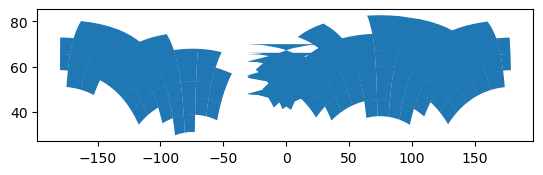

In [31]:
asset_properties_gdf.plot()

In [32]:
#fishnet_4326.explore()

In [33]:
# Notice the AGG_TILE_NUM doesnt match index locs, which is ok
agg_tile_num_list =  asset_properties_gdf.AGG_TILE_NUM.to_list()
keys = asset_properties_gdf.index.to_list()
print(dict(zip(keys, agg_tile_num_list)))

{0: 1, 1: 2, 2: 3, 3: 4, 4: 5, 5: 6, 6: 7, 7: 8, 8: 9, 9: 10, 10: 101, 11: 102, 12: 103, 13: 104, 14: 105, 15: 106, 16: 107, 17: 108, 18: 109, 19: 11, 20: 110, 21: 12, 22: 13, 23: 14, 24: 15, 25: 16, 26: 17, 27: 18, 28: 19, 29: 20, 30: 21, 31: 22, 32: 23, 33: 24, 34: 25, 35: 26, 36: 27, 37: 28, 38: 29, 39: 30, 40: 31, 41: 32, 42: 33, 43: 34, 44: 35, 45: 36, 46: 37, 47: 38, 48: 39, 49: 40, 50: 41, 51: 42, 52: 43, 53: 44, 54: 45, 55: 46, 56: 47, 57: 48, 58: 49, 59: 50, 60: 51, 61: 52, 62: 53, 63: 54, 64: 55, 65: 56, 66: 57, 67: 58, 68: 59, 69: 60, 70: 61, 71: 62, 72: 63, 73: 64, 74: 65, 75: 66, 76: 67, 77: 68, 78: 69, 79: 70, 80: 71, 81: 72, 82: 73, 83: 74, 84: 75, 85: 76, 86: 77, 87: 78, 88: 79, 89: 80, 90: 81, 91: 82, 92: 83, 93: 84, 94: 85, 95: 86, 96: 87, 97: 88, 98: 89, 99: 90, 100: 91, 101: 92, 102: 95, 103: 96, 104: 97, 105: 98, 106: 99}


In [ ]:
region  = fishnet_df.iloc[0]
minx, miny, maxx, maxy = region.geometry.bounds
region_ee = ee.Geometry.BBox(minx, miny, maxx, maxy)
region_ee

In [ ]:
# Pulled out from loop below for testing
do_gee_download_by_subtile.do_gee_download_by_subtile(index, TILELOC=TILELOC, fishnet=fishnet_df, asset_df=asset_df, OUTDIR=OUTDIR_TILE)

In [196]:
import do_gee_download_by_subtile
import export_gee_to_maap
import ee_download

import importlib
importlib.reload(do_gee_download_by_subtile)
importlib.reload(export_gee_to_maap)
importlib.reload(ee_download)

<module 'ee_download' from '/projects/code/icesat2_boreal/lib/ee_download.py'>

In [197]:
OUTDIR

'/projects/my-public-bucket/export_gee_to_maap_v2'

In [198]:
%%time

ASSET_PATH = 'projects/foreststructure/Circumboreal/S1_Composites_albers'

# Append indiv asset tile gdf to this list to concat into a final gdf of all subtiles from all asset tiles
fishnet_4326_list = []

#for TILELOC in asset_df.index.to_list():
for TILELOC in [3]:
    
    #### IF DPSing by subtile, you need TILELOC and ASSET_PATH to get gee asset_df and the tile fishnet even before you call 'do_gee_download_by_subtile'
    
    # We need this asset_df to know how to loop over asset tiles - but the script also needs it during processing and to use it to build a fishnet_df 
    asset_df = do_gee_download_by_subtile.get_gee_assets(ASSET_PATH)
    ASSET_TILE_NAME = os.path.basename(asset_df.id.to_list()[TILELOC])
    
    # --- THIS IS NOW MADE IN do_gee_download_by_subtile
    # Make asset tile subdir
    OUTDIR_TILE = os.path.join(OUTDIR, ASSET_TILE_NAME)
    if not os.path.exists(OUTDIR_TILE):
        os.makedirs(OUTDIR_TILE)
    
    #print(f'GEE Asset tile loc position # {TILELOC} in subdir: {OUTDIR_TILE}')
    print(f'GEE Asset tile loc # {TILELOC} will go an asset tile dir: {ASSET_TILE_NAME}')
    
    fishnet_df = do_gee_download_by_subtile.create_fishnet(asset_df, TILELOC, 500)
    fishnet_df['subtile'] = fishnet_df.index
    fishnet_df['tile'] = TILELOC
    
    # iterate over fishnet and import GEE image
    fishnet_4326 = fishnet_df.to_crs("EPSG:4326")
    
    ## This will multprocess the glob for unfinished subtiles
    # Get full index list
    LIST_INDEX_TO_PROCESS = [index for index, row in fishnet_4326.iterrows()]
    
    if False:
        # Only needed to eliminate replication of subtile processing during local re-runs across an asset tile
        with Pool(processes=25) as pool:
            LIST_INDEX_TO_PROCESS = pool.map(partial(find_index_to_process, OUTDIR_TILE=OUTDIR_TILE), LIST_INDEX_TO_PROCESS)

        # Get rid of Nones in list
        LIST_INDEX_TO_PROCESS = [index for index in LIST_INDEX_TO_PROCESS if index is not None]
    
    print(f'\t{len(LIST_INDEX_TO_PROCESS)} subtiles to process')
    
    #
    # Process the subtile download for this GEE asset tile
    # note: both cause transport endpoint disconnects... need to DPS
    # replace this with maap.submitJob()
    # 
    if True:
        # Loop
        #for index in LIST_INDEX_TO_PROCESS: #<------------CHANGE THIS AFTER TESTS
        LIST_FOR_TEST = [LIST_INDEX_TO_PROCESS[x] for x in list(range(3,7))+list(range(55,59)) ]
        for index in LIST_FOR_TEST:
            args = ''
            if False:
                # Test of imported function
                #do_gee_download_by_subtile.do_gee_download_by_subtile(index, TILELOC=TILELOC, fishnet=fishnet_df, asset_df=asset_df, OUTDIR=OUTDIR_TILE)
                do_gee_download_by_subtile.do_gee_download_by_subtile(SUBTILE_LOC=index, TILELOC=TILELOC, ASSET_PATH=ASSET_PATH, OUTDIR=OUTDIR_TILE)
            else:
                # Test of cmd line main function
                args += f'--subtile_loc {index} '
                args += f'--tile_loc {TILELOC} '
                args += f'--asset_path {ASSET_PATH} '
                args += f'--out_dir {OUTDIR_TILE} '
                !python /projects/code/icesat2_boreal/lib/do_gee_download_by_subtile.py $args
    else:
        # Multiprocess
        with Pool(processes=25) as pool:
            fails = pool.map(partial(do_gee_download_by_subtile.do_gee_download_by_subtile, TILELOC=TILELOC, fishnet=fishnet_df, asset_df=asset_df, OUTDIR=OUTDIR_TILE ), LIST_INDEX_TO_PROCESS)

    fishnet_4326_list.append(fishnet_4326)

final_fishnet_gdf = pd.concat(fishnet_4326_list)
final_fishnet_gdf.to_file(os.path.join(OUTDIR, 'final_fishnet.gpkg'), driver='GPKG')

GEE Asset tile loc # 3 will go an asset tile dir: s1_vv_vh_gamma_2018_pwr_tile04
	asset id = projects/foreststructure/Circumboreal/S1_Composites_albers/s1_vv_vh_gamma_2018_pwr_tile04
	rows = 27478 cols =  27585
	3080 subtiles to process

	Subtile 3 for tile loc 3 to subdir: /projects/my-public-bucket/export_gee_to_maap_v2/s1_vv_vh_gamma_2018_pwr_tile04/s1_vv_vh_gamma_2018_pwr_tile04
	asset id = projects/foreststructure/Circumboreal/S1_Composites_albers/s1_vv_vh_gamma_2018_pwr_tile04
	rows = 27478 cols =  27585
	SUBTILE_LOC: 3 : extracted tifs to /projects/my-public-bucket/export_gee_to_maap_v2/s1_vv_vh_gamma_2018_pwr_tile04/s1_vv_vh_gamma_2018_pwr_tile04-subtile000003

	Subtile 4 for tile loc 3 to subdir: /projects/my-public-bucket/export_gee_to_maap_v2/s1_vv_vh_gamma_2018_pwr_tile04/s1_vv_vh_gamma_2018_pwr_tile04
	asset id = projects/foreststructure/Circumboreal/S1_Composites_albers/s1_vv_vh_gamma_2018_pwr_tile04
	rows = 27478 cols =  27585
	SUBTILE_LOC: 4 : extracted tifs to /project

In [195]:
# S3_PATH = f's3://maap-ops-workspace/shared/montesano/{os.path.basename(OUTDIR)}/'
# !aws s3 rm --quiet --recursive $S3_PATH
# !mkdir -p $OUTDIR